<h1>Контекст проекта</h1>

Люди используют черты лица или мимику, чтобы передать свои чувства, например, человек может улыбаться, когда счастлив, и хмуриться, когда сердит. Исторически исследования в области компьютерного зрения были сосредоточены на анализе и изучении этих черт лица для распознавания эмоций.
Однако эти черты лица не являются универсальными и сильно различаются в разных культурах и ситуациях.

<figure>
<img src="https://raw.githubusercontent.com/Tandon-A/emotic/master/assets/face.jpg"> <img src="https://raw.githubusercontent.com/Tandon-A/emotic/master/assets/full_scene.jpg" width="400">
  <figcaption>Fig 1: a) (Facial feature) The person looks angry or in pain b) (Whole scene) The person looks elated.</figcaption>
</figure>


Контекст сцены, как показано на рисунке выше, может предоставить дополнительную информацию о ситуациях. В этом проекте исследуется использование контекста для распознавания эмоций на изображениях.

Этот проект использует <a href="http://sunai.uoc.edu/emotic/download.html">набор данных об эмоциях</a> и следует методологии, представленной в статье <a href="https://arxiv.org/pdf/2003.13401.pdf"> "Распознавание эмоций на основе контекста с использованием набора данных об эмоциях"</a>.ё

In [1]:
# Linking Google drive to use preprocessed data
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
#/content/drive/My Drive//

Mounted at /content/drive


# I. Готовим предобученные модели

In [2]:
# Get Resnet18 model trained on places dataset.
!mkdir ./places
!wget http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar -O ./places/resnet18_places365.pth.tar

--2024-12-10 08:27:47--  http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar
Resolving places2.csail.mit.edu (places2.csail.mit.edu)... 128.52.132.120
Connecting to places2.csail.mit.edu (places2.csail.mit.edu)|128.52.132.120|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45506139 (43M) [application/x-tar]
Saving to: ‘./places/resnet18_places365.pth.tar’

./places/resnet18_p 100%[===================>]  43.40M  91.3MB/s    in 0.5s    

2024-12-10 08:27:48 (91.3 MB/s) - ‘./places/resnet18_places365.pth.tar’ saved [45506139/45506139]



In [3]:
# Saving the model weights to use ahead in the notebook
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from PIL import Image
from torchvision import transforms as trn
from torch.nn import functional as F
import os

# the architecture to use
arch = 'resnet18'
model_weight = os.path.join('./places', 'resnet18_places365.pth.tar')

# create the network architecture
model = models.__dict__[arch](num_classes=365)

#model_weight = '%s_places365.pth.tar' % arch

checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model trained in GPU could be deployed in CPU machine like this!
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()} # the data parallel layer will add 'module' before each layer name
model.load_state_dict(state_dict)
model.eval()

model.cpu()
torch.save(model.state_dict(), './places/resnet18_state_dict.pth')
print ('completed cell')

completed cell


<ipython-input-3-b8843e7c1549>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_weight, map_location=lambda storage, loc: storage) # model tra

# II. Загружаем библиотеки

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import scipy.io
from sklearn.metrics import average_precision_score, precision_recall_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

print ('completed cell')

completed cell


# III. Emotic классы

## Emotic модель

In [5]:
class Emotic(nn.Module):
  ''' Emotic Model'''
  def __init__(self, num_context_features, num_body_features):
    super(Emotic,self).__init__()
    self.num_context_features = num_context_features
    self.num_body_features = num_body_features
    self.fc1 = nn.Linear((self.num_context_features + num_body_features), 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.d1 = nn.Dropout(p=0.5)
    self.fc_cat = nn.Linear(256, 26)
    self.fc_cont = nn.Linear(256, 3)
    self.relu = nn.ReLU()


  def forward(self, x_context, x_body):
    context_features = x_context.view(-1, self.num_context_features)
    body_features = x_body.view(-1, self.num_body_features)
    fuse_features = torch.cat((context_features, body_features), 1)
    fuse_out = self.fc1(fuse_features)
    fuse_out = self.bn1(fuse_out)
    fuse_out = self.relu(fuse_out)
    fuse_out = self.d1(fuse_out)
    cat_out = self.fc_cat(fuse_out)
    cont_out = self.fc_cont(fuse_out)
    return cat_out, cont_out

print ('completed cell')

completed cell


## Emotic датасет

In [6]:
class Emotic_PreDataset(Dataset):
  ''' Custom Emotic dataset class. Use preprocessed data stored in npy files. '''
  def __init__(self, x_context, x_body, y_cat, y_cont, transform, context_norm, body_norm):
    super(Emotic_PreDataset,self).__init__()
    self.x_context = x_context
    self.x_body = x_body
    self.y_cat = y_cat
    self.y_cont = y_cont
    self.transform = transform
    self.context_norm = transforms.Normalize(context_norm[0], context_norm[1])  # Normalizing the context image with context mean and context std
    self.body_norm = transforms.Normalize(body_norm[0], body_norm[1])           # Normalizing the body image with body mean and body std

  def __len__(self):
    return len(self.y_cat)

  def __getitem__(self, index):
    image_context = self.x_context[index]
    image_body = self.x_body[index]
    cat_label = self.y_cat[index]
    cont_label = self.y_cont[index]
    return self.context_norm(self.transform(image_context)), self.body_norm(self.transform(image_body)), torch.tensor(cat_label, dtype=torch.float32), torch.tensor(cont_label, dtype=torch.float32)/10.0

print ('completed cell')

completed cell


## Loss модели

In [7]:
class DiscreteLoss(nn.Module):
  ''' Class to measure loss between categorical emotion predictions and labels.'''
  def __init__(self, weight_type='mean', device=torch.device('cpu')):
    super(DiscreteLoss, self).__init__()
    self.weight_type = weight_type
    self.device = device
    if self.weight_type == 'mean':
      self.weights = torch.ones((1,26))/26.0
      self.weights = self.weights.to(self.device)
    elif self.weight_type == 'static':
      self.weights = torch.FloatTensor([0.1435, 0.1870, 0.1692, 0.1165, 0.1949, 0.1204, 0.1728, 0.1372, 0.1620,
         0.1540, 0.1987, 0.1057, 0.1482, 0.1192, 0.1590, 0.1929, 0.1158, 0.1907,
         0.1345, 0.1307, 0.1665, 0.1698, 0.1797, 0.1657, 0.1520, 0.1537]).unsqueeze(0)
      self.weights = self.weights.to(self.device)

  def forward(self, pred, target):
    if self.weight_type == 'dynamic':
      self.weights = self.prepare_dynamic_weights(target)
      self.weights = self.weights.to(self.device)
    loss = (((pred - target)**2) * self.weights)
    return loss.sum()

  def prepare_dynamic_weights(self, target):
    target_stats = torch.sum(target, dim=0).float().unsqueeze(dim=0).cpu()
    weights = torch.zeros((1,26))
    weights[target_stats != 0 ] = 1.0/torch.log(target_stats[target_stats != 0].data + 1.2)
    weights[target_stats == 0] = 0.0001
    return weights


class ContinuousLoss_L2(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using l2 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_L2, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = labs ** 2
    loss[ (labs < self.margin) ] = 0.0
    return loss.sum()


class ContinuousLoss_SL1(nn.Module):
  ''' Class to measure loss between continuous emotion dimension predictions and labels. Using smooth l1 loss as base. '''
  def __init__(self, margin=1):
    super(ContinuousLoss_SL1, self).__init__()
    self.margin = margin

  def forward(self, pred, target):
    labs = torch.abs(pred - target)
    loss = 0.5 * (labs ** 2)
    loss[ (labs > self.margin) ] = labs[ (labs > self.margin) ] - 0.5
    return loss.sum()

print ('completed cell')

completed cell


# IV. Загружаем начальные данные

In [8]:
# Change data_src variable as per your drive
data_src = '/content/drive/MyDrive/emotic_pre'


# Load training preprocessed data
train_context = np.load(os.path.join(data_src,'train_context_arr.npy'))
train_body = np.load(os.path.join(data_src,'train_body_arr.npy'))
train_cat = np.load(os.path.join(data_src,'train_cat_arr.npy'))
train_cont = np.load(os.path.join(data_src,'train_cont_arr.npy'))

# Load validation preprocessed data
val_context = np.load(os.path.join(data_src,'val_context_arr.npy'))
val_body = np.load(os.path.join(data_src,'val_body_arr.npy'))
val_cat = np.load(os.path.join(data_src,'val_cat_arr.npy'))
val_cont = np.load(os.path.join(data_src,'val_cont_arr.npy'))

# Load testing preprocessed data
test_context = np.load(os.path.join(data_src,'test_context_arr.npy'))
test_body = np.load(os.path.join(data_src,'test_body_arr.npy'))
test_cat = np.load(os.path.join(data_src,'test_cat_arr.npy'))
test_cont = np.load(os.path.join(data_src,'test_cont_arr.npy'))

# Categorical emotion classes
cat = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
       'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
       'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']

cat2ind = {}
ind2cat = {}
for idx, emotion in enumerate(cat):
  cat2ind[emotion] = idx
  ind2cat[idx] = emotion

print ('train ', 'context ', train_context.shape, 'body', train_body.shape, 'cat ', train_cat.shape, 'cont', train_cont.shape)
print ('val ', 'context ', val_context.shape, 'body', val_body.shape, 'cat ', val_cat.shape, 'cont', val_cont.shape)
print ('test ', 'context ', test_context.shape, 'body', test_body.shape, 'cat ', test_cat.shape, 'cont', test_cont.shape)
print ('completed cell')

train  context  (23266, 224, 224, 3) body (23266, 128, 128, 3) cat  (23266, 26) cont (23266, 3)
val  context  (3315, 224, 224, 3) body (3315, 128, 128, 3) cat  (3315, 26) cont (3315, 3)
test  context  (7203, 224, 224, 3) body (7203, 128, 128, 3) cat  (7203, 26) cont (7203, 3)
completed cell


In [9]:
batch_size = 26

context_mean = [0.4690646, 0.4407227, 0.40508908]
context_std = [0.2514227, 0.24312855, 0.24266963]
body_mean = [0.43832874, 0.3964344, 0.3706214]
body_std = [0.24784276, 0.23621225, 0.2323653]
context_norm = [context_mean, context_std]
body_norm = [body_mean, body_std]


train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor()])

train_dataset = Emotic_PreDataset(train_context, train_body, train_cat, train_cont, \
                                  train_transform, context_norm, body_norm)
val_dataset = Emotic_PreDataset(val_context, val_body, val_cat, val_cont, \
                                test_transform, context_norm, body_norm)
test_dataset = Emotic_PreDataset(test_context, test_body, test_cat, test_cont, \
                                 test_transform, context_norm, body_norm)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))
print ('completed cell')

train loader  894 val loader  128 test 278
completed cell


# V. Готовим emotic модель

In [10]:
model_path_places = './places'

model_context = models.__dict__[arch](num_classes=365)
context_state_dict = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'))
model_context.load_state_dict(context_state_dict)

model_body = models.resnet18(pretrained=True)

emotic_model = Emotic(list(model_context.children())[-1].in_features, list(model_body.children())[-1].in_features)
model_context = nn.Sequential(*(list(model_context.children())[:-1]))
model_body = nn.Sequential(*(list(model_body.children())[:-1]))


# print (summary(model_context, (3,224,224), device="cpu"))
# print (summary(model_body, (3,128,128), device="cpu"))

print ('completed cell')

<ipython-input-10-971039c868c3>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  context_state_dict = torch.load(os.path.join(model_path_places, 'resnet18_state_dict.pth'))


completed cell


## Готовим оптимизатор

In [11]:
for param in emotic_model.parameters():
  param.requires_grad = True
for param in model_context.parameters():
  param.requires_grad = False
for param in model_body.parameters():
  param.requires_grad = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.Adam((list(emotic_model.parameters()) + list(model_context.parameters()) + \
                  list(model_body.parameters())), lr=0.001, weight_decay=5e-4)
scheduler = StepLR(opt, step_size=7, gamma=0.1)

disc_loss = DiscreteLoss('dynamic', device)
cont_loss_SL1 = ContinuousLoss_SL1()

print ('completed cell')

completed cell


# VI. Обучение модели

In [12]:
def train_emotic(epochs, model_path, opt, scheduler, models, disc_loss, cont_loss, cat_loss_param=0.5, cont_loss_param=0.5):
  if not os.path.exists(model_path):
    os.makedirs(model_path)

  min_loss = np.inf

  train_loss = list()
  val_loss = list()

  model_context, model_body, emotic_model = models

  for e in range(epochs):
    running_loss = 0.0

    emotic_model.to(device)
    model_context.to(device)
    model_body.to(device)

    emotic_model.train()
    model_context.train()
    model_body.train()

    for images_context, images_body, labels_cat, labels_cont in iter(train_loader):
      images_context = images_context.to(device)
      images_body = images_body.to(device)
      labels_cat = labels_cat.to(device)
      labels_cont = labels_cont.to(device)

      opt.zero_grad()

      pred_context = model_context(images_context)
      pred_body = model_body(images_body)

      pred_cat, pred_cont = emotic_model(pred_context, pred_body)
      cat_loss_batch = disc_loss(pred_cat, labels_cat)
      cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
      loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param * cont_loss_batch)
      running_loss += loss.item()
      loss.backward()
      opt.step()

    if e % 1 == 0:
      print ('epoch = %d training loss = %.4f' %(e, running_loss))
    train_loss.append(running_loss)


    running_loss = 0.0
    emotic_model.eval()
    model_context.eval()
    model_body.eval()

    with torch.no_grad():
      for images_context, images_body, labels_cat, labels_cont in iter(val_loader):
        images_context = images_context.to(device)
        images_body = images_body.to(device)
        labels_cat = labels_cat.to(device)
        labels_cont = labels_cont.to(device)

        pred_context = model_context(images_context)
        pred_body = model_body(images_body)

        pred_cat, pred_cont = emotic_model(pred_context, pred_body)
        cat_loss_batch = disc_loss(pred_cat, labels_cat)
        cont_loss_batch = cont_loss(pred_cont * 10, labels_cont * 10)
        loss = (cat_loss_param * cat_loss_batch) + (cont_loss_param * cont_loss_batch)
        running_loss += loss.item()

      if e % 1 == 0:
        print ('epoch = %d validation loss = %.4f' %(e, running_loss))
    val_loss.append(running_loss)

    scheduler.step()

    if val_loss[-1] < min_loss:
        min_loss = val_loss[-1]
        # saving models for lowest loss
        print ('saving model at epoch e = %d' %(e))
        emotic_model.to("cpu")
        model_context.to("cpu")
        model_body.to("cpu")
        torch.save(emotic_model, os.path.join(model_path, 'model_emotic1.pth'))
        torch.save(model_context, os.path.join(model_path, 'model_context1.pth'))
        torch.save(model_body, os.path.join(model_path, 'model_body1.pth'))

  print ('completed training')

  f, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 6))
  f.suptitle('emotic')
  ax1.plot(range(0,len(train_loss)),train_loss, color='Blue')
  ax2.plot(range(0,len(val_loss)),val_loss, color='Red')
  ax1.legend(['train'])
  ax2.legend(['val'])

print ('completed cell')

completed cell


In [14]:
model_context = torch.load('model_context1.pth')
model_body = torch.load('model_body1.pth')
emotic_model = torch.load('model_emotic1.pth')

print ('completed cell')

<ipython-input-14-dcaf464d1ba9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_context = torch.load('model_context1.pth')
<ipython-input-14-dcaf464d1ba9>:2: FutureWa

completed cell


<ipython-input-14-dcaf464d1ba9>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emotic_model = torch.load('model_emotic1.pth')


In [ ]:
train_emotic(100, './models', opt, scheduler, [model_context, model_body, emotic_model], disc_loss, cont_loss_SL1)

epoch = 0 training loss = 41051.0994
epoch = 0 validation loss = 5531.7721
saving model at epoch e = 0
epoch = 1 training loss = 40978.6537
epoch = 1 validation loss = 5526.2724
saving model at epoch e = 1
epoch = 2 training loss = 40946.5941
epoch = 2 validation loss = 5525.3362
saving model at epoch e = 2
epoch = 3 training loss = 41037.5615
epoch = 3 validation loss = 5533.5790
epoch = 4 training loss = 41028.2845
epoch = 4 validation loss = 5535.9871
epoch = 5 training loss = 41094.8171
epoch = 5 validation loss = 5523.1454
saving model at epoch e = 5
epoch = 6 training loss = 41073.5536
epoch = 6 validation loss = 5521.6526
saving model at epoch e = 6
epoch = 7 training loss = 41026.2182
epoch = 7 validation loss = 5520.5757
saving model at epoch e = 7
epoch = 8 training loss = 40979.3061
epoch = 8 validation loss = 5514.3405
saving model at epoch e = 8
epoch = 9 training loss = 41049.8837
epoch = 9 validation loss = 5512.6938
saving model at epoch e = 9
epoch = 10 training loss =

# VII. Тесты модели

In [15]:
def test_scikit_ap(cat_preds, cat_labels):
  ap = np.zeros(26, dtype=np.float32)
  for i in range(26):
    ap[i] = average_precision_score(cat_labels[i, :], cat_preds[i, :])
  print ('ap', ap, ap.shape, ap.mean())
  return ap.mean()


def test_emotic_vad(cont_preds, cont_labels):
  vad = np.zeros(3, dtype=np.float32)
  for i in range(3):
    vad[i] = np.mean(np.abs(cont_preds[i, :] - cont_labels[i, :]))
  print ('vad', vad, vad.shape, vad.mean())
  return vad.mean()


def get_thresholds(cat_preds, cat_labels):
  thresholds = np.zeros(26, dtype=np.float32)
  for i in range(26):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  np.save('./thresholds.npy', thresholds)
  return thresholds

print ('completed cell')

completed cell


In [16]:
def test_data(models, device, data_loader, num_images):
    model_context, model_body, emotic_model = models
    cat_preds = np.zeros((num_images, 26))
    cat_labels = np.zeros((num_images, 26))
    cont_preds = np.zeros((num_images, 3))
    cont_labels = np.zeros((num_images, 3))

    with torch.no_grad():
        model_context.to(device)
        model_body.to(device)
        emotic_model.to(device)
        model_context.eval()
        model_body.eval()
        emotic_model.eval()
        indx = 0
        print ('starting testing')
        for images_context, images_body, labels_cat, labels_cont in iter(data_loader):
            images_context = images_context.to(device)
            images_body = images_body.to(device)

            pred_context = model_context(images_context)
            pred_body = model_body(images_body)
            pred_cat, pred_cont = emotic_model(pred_context, pred_body)

            cat_preds[ indx : (indx + pred_cat.shape[0]), :] = pred_cat.to("cpu").data.numpy()
            cat_labels[ indx : (indx + labels_cat.shape[0]), :] = labels_cat.to("cpu").data.numpy()
            cont_preds[ indx : (indx + pred_cont.shape[0]), :] = pred_cont.to("cpu").data.numpy() * 10
            cont_labels[ indx : (indx + labels_cont.shape[0]), :] = labels_cont.to("cpu").data.numpy() * 10
            indx = indx + pred_cat.shape[0]

    cat_preds = cat_preds.transpose()
    cat_labels = cat_labels.transpose()
    cont_preds = cont_preds.transpose()
    cont_labels = cont_labels.transpose()
    scipy.io.savemat('./cat_preds.mat',mdict={'cat_preds':cat_preds})
    scipy.io.savemat('./cat_labels.mat',mdict={'cat_labels':cat_labels})
    scipy.io.savemat('./cont_preds.mat',mdict={'cont_preds':cont_preds})
    scipy.io.savemat('./cont_labels.mat',mdict={'cont_labels':cont_labels})
    print ('completed testing')
    ap_mean = test_scikit_ap(cat_preds, cat_labels)
    vad_mean = test_emotic_vad(cont_preds, cont_labels)
    print (ap_mean, vad_mean)
    return ap_mean, vad_mean

print ('completed cell')

completed cell


In [17]:
val_ap, val_vad = test_data([model_context, model_body, emotic_model], device, val_loader, val_dataset.__len__())
test_ap, test_vad = test_data([model_context, model_body, emotic_model], device, test_loader, test_dataset.__len__())

print ('validation Mean average precision=%.4f Mean VAD MAE=%.4f' %(val_ap, val_vad))
print ('testing Mean average precision=%.4f Mean VAD MAE=%.4f' %(test_ap, test_vad))

starting testing
completed testing
ap [0.40922844 0.18364765 0.23438004 0.94999725 0.18463752 0.79137766
 0.2517399  0.36873484 0.19055805 0.20751822 0.0656309  0.97971904
 0.25045106 0.798902   0.13007703 0.08872575 0.810394   0.18065119
 0.2935436  0.5015887  0.22413789 0.07543632 0.20250647 0.14518319
 0.36860713 0.1165185 ] (26,) 0.34630358
vad [0.7061385 0.8476022 0.892568 ] (3,) 0.8154362
0.34630358 0.8154362
starting testing
completed testing
ap [0.2899443  0.09390978 0.14419246 0.5630309  0.06902088 0.76059765
 0.12543702 0.23948519 0.15953569 0.17137823 0.0208785  0.8672814
 0.15773457 0.69390523 0.0990133  0.06454572 0.6667747  0.07470154
 0.22103061 0.42126885 0.17858306 0.06704555 0.17985179 0.08905777
 0.13086188 0.07824982] (26,) 0.25489676
vad [0.90788275 1.0216782  0.9531508 ] (3,) 0.9609039
0.25489676 0.9609039
validation Mean average precision=0.3463 Mean VAD MAE=0.8154
testing Mean average precision=0.2549 Mean VAD MAE=0.9609


In [18]:
cat_labels = scipy.io.loadmat('./cat_labels.mat')
cat_preds = scipy.io.loadmat('./cat_preds.mat')
cat_preds = cat_preds['cat_preds']
cat_labels = cat_labels['cat_labels']
print (cat_preds.shape, cat_labels.shape)

#thesholds calculation for inference
thresholds = get_thresholds(cat_preds, cat_labels)
print (thresholds, thresholds.shape)

print ('completed cell')

(26, 7203) (26, 7203)
[0.12297233 0.3204806  0.17077783 0.18275198 0.24365985 0.13967773
 0.22184129 0.10551999 0.07433749 0.07402138 0.12857494 0.4686156
 0.07554874 0.15424272 0.12054616 0.12409322 0.2255113  0.25835595
 0.10988013 0.         0.18667494 0.15603824 0.26307932 0.09445424
 0.10431278 0.08825529] (26,)
completed cell


In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def evaluate_emotic_predictions(pred_cat, pred_cont, set_name=""):
    """
    Evaluate EMOTIC model predictions for both categorical and continuous (VAD) predictions
    pred_cat: categorical emotion predictions
    pred_cont: continuous VAD predictions
    """
    # Convert continuous scores to binary predictions using threshold for categorical emotions
    threshold = 0.5
    pred_binary = (pred_cat > threshold).astype(int)

    # Calculate metrics for each emotion
    n_emotions = pred_cat.shape[1]
    emotion_names = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion',
                    'Confidence', 'Disapproval', 'Disconnection', 'Disquietment',
                    'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem',
                    'Excitement', 'Fatigue', 'Fear', 'Happiness', 'Pain',
                    'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering',
                    'Surprise', 'Sympathy', 'Yearning']

    # Plot distribution of predictions
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(pred_binary.mean(axis=0).reshape(1, -1),
                annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=emotion_names, yticklabels=['Mean Activation'])
    plt.title(f'Mean Emotion Activations - {set_name}')
    plt.xticks(rotation=45, ha='right')

    # Plot VAD distributions
    plt.subplot(1, 2, 2)
    vad_names = ['Valence', 'Arousal', 'Dominance']
    sns.boxplot(data=pd.DataFrame(pred_cont, columns=vad_names))
    plt.title(f'VAD Distributions - {set_name}')
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\nSummary Statistics for {set_name}:")
    print("\nCategorical Emotions:")
    print("Mean activation per emotion:")
    for emotion, mean_act in zip(emotion_names, pred_binary.mean(axis=0)):
        print(f"{emotion}: {mean_act:.3f}")

    print("\nVAD Statistics:")
    print("Mean VAD values:")
    for dim, mean_val in zip(vad_names, pred_cont.mean(axis=0)):
        print(f"{dim}: {mean_val:.3f}")

# Evaluate validation set
print("Validation Set Evaluation:")
evaluate_emotic_predictions(val_ap, val_vad, "Validation Set")

# Evaluate test set
print("\nTest Set Evaluation:")
evaluate_emotic_predictions(test_ap, test_vad, "Test Set")

Validation Set Evaluation:


IndexError: tuple index out of range

# Тесты

In [ ]:
!apt install octave

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  aglfn default-jre-headless epstool fonts-droid-fallback fonts-freefont-otf fonts-noto-mono
  fonts-urw-base35 ghostscript gnuplot-data gnuplot-qt gsfonts imagemagick-6-common info
  install-info libamd2 libauthen-sasl-perl libbtf1 libcamd2 libccolamd2 libcholmod3 libclone-perl
  libcolamd2 libcombblas1.16.0 libcxsparse3 libdata-dump-perl libemf1 libencode-locale-perl
  libevdev2 libfftw3-double3 libfftw3-long3 libfftw3-mpi3 libfftw3-single3 libfile-listing-perl
  libfltk-gl1.3 libfltk1.3 libfont-afm-perl libglpk40 libglu1-mesa libgraphicsmagick++-q16-12
  libgraphicsmagick-q16-3 libgs9 libgs9-common libgudev-1.0-0 libhdf5-openmpi-103-1
  libhtml-form-perl libhtml-format-perl libhtml-parser-perl libhtml-tagset-perl libhtml-tree-perl
  libhttp-cookies-perl libhttp-daemon-perl libhttp-date-perl libhttp-message-perl
  libhttp-negotiate-perl

In [ ]:
%%writefile eval.m

gt = load('./cat_labels.mat')
gt = gt.cat_labels

pred = load('./cat_preds.mat')
pred = pred.cat_preds

categories{1} = 'Affection';
categories{2} = 'Anger';
categories{3} = 'Annoyance';
categories{4} = 'Anticipation';
categories{5} = 'Aversion';
categories{6} = 'Confidence';
categories{7} = 'Disapproval';
categories{8} = 'Disconnection';
categories{9} = 'Disquietment';
categories{10} = 'Doubt/Confusion';
categories{11} = 'Embarrassment';
categories{12} = 'Engagement';
categories{13} = 'Esteem';
categories{14} = 'Excitement';
categories{15} = 'Fatigue';
categories{16} = 'Fear';
categories{17} = 'Happiness';
categories{18} = 'Pain';
categories{19} = 'Peace';
categories{20} = 'Pleasure';
categories{21} = 'Sadness';
categories{22} = 'Sensitivity';
categories{23} = 'Suffering';
categories{24} = 'Surprise';
categories{25} = 'Sympathy';
categories{26} = 'Yearning';


for c = 1:length(categories)
  confidence = pred(c,:)';
  testClass = gt(c,:)';
  confidence = double(confidence);

  S = rand('state');
  rand('state',0);
  confidence = confidence + rand(size(confidence))*10^(-10);
  rand('state',S)

  [S,j] = sort(-confidence);
  C = testClass(j);
  n = length(C);

  REL = sum(C);
  if n>0
    RETREL = cumsum(C);
    RET    = (1:n)';
  else
    RETREL = 0;
    RET    = 1;
  end

  precision = 100*RETREL ./ RET;
  recall    = 100*RETREL  / REL;
  th = -S;

  % compute AP
  mrec=[0 ; recall ; 100];
  mpre=[0 ; precision ; 0];
  for i=numel(mpre)-1:-1:1
    mpre(i)=max(mpre(i),mpre(i+1));
  end
  i=find(mrec(2:end)~=mrec(1:end-1))+1;
  averagePrecision=sum((mrec(i)-mrec(i-1)).*mpre(i))/100;
  ap_list(c)  = averagePrecision
end

display('#######################################')

display('Average precision of predictions');
for c = 1:length(categories)
    sp = '............................';
    cat = strcat(categories{c}, sp);
    cat = cat(1:18);
    display(cat);
    display(ap_list(c));
end

Writing eval.m


In [ ]:
!octave -W eval.m

Выходные данные были обрезаны до нескольких последних строк (5000).
   6.3896e-02   8.3304e-02   2.3977e-02  -1.5554e-03   9.0482e-02   7.1967e-02
   3.1589e-02   3.4297e-02   7.3078e-02   6.3250e-03   1.8690e-02   1.3735e-01
   3.9169e-02   5.0939e-02   5.7468e-02   2.3033e-03   3.9267e-02   1.4529e-01
   5.9734e-02   3.1764e-02   7.4577e-02   4.1205e-02   1.5811e-02   1.1334e-01
   5.2562e-01   5.9663e-01   5.2722e-01   6.2941e-01   5.6500e-01   3.5018e-01
   8.3191e-02   3.5043e-02   3.8485e-02   5.5686e-02   3.5352e-02   8.5021e-02
   1.5734e-01   1.2926e-01   3.0830e-01   3.7722e-01   7.8911e-02   5.5651e-02
   5.4662e-02   4.6317e-02   3.5718e-02   3.3733e-02   5.8980e-02   1.0577e-01
   2.5214e-02   2.4203e-02   9.9057e-02   3.5575e-02   3.1169e-02   1.0803e-01
   2.5912e-01   1.5893e-01   2.3969e-01   1.2124e-01   2.1895e-01   2.5274e-01
   3.2863e-02   8.6869e-03   5.7187e-02   2.1861e-03   1.7492e-02   9.8544e-02
   4.3879e-02   7.4614e-02   7.1222e-02  -1.6258e-02   1.1162e-

In [30]:

import scipy.io

# Load the predictions and ground truth from the .mat files
cat_labels = scipy.io.loadmat('./cat_labels.mat')
cat_preds = scipy.io.loadmat('./cat_preds.mat')
cat_preds = cat_preds['cat_preds']
cat_labels = cat_labels['cat_labels']

# Calculate F1-score for each category
f1_scores = []
for i in range(26):
    f1 = f1_score(cat_labels[i, :], (cat_preds[i, :] > 0.5).astype(int))  # Using a threshold of 0.5
    f1_scores.append(f1)

# Calculate the mean F1-score
mean_f1 = np.mean(f1_scores)
print(f"Mean F1-score: {mean_f1}")

# Print F1-score for each category
categories = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
              'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
              'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']
for i, f1 in enumerate(f1_scores):
  print(f"{categories[i]}: {f1}")

Mean F1-score: 0.06079820291208615
Affection: 0.008290155440414507
Anger: 0.12931034482758622
Annoyance: 0.08174386920980926
Anticipation: 0.0747301411569333
Aversion: 0.05194805194805195
Confidence: 0.0274442538593482
Disapproval: 0.08379888268156424
Disconnection: 0.0
Disquietment: 0.0
Doubt/Confusion: 0.0
Embarrassment: 0.0
Engagement: 0.7887807670291929
Esteem: 0.0
Excitement: 0.025
Fatigue: 0.0
Fear: 0.0
Happiness: 0.13509234828496042
Pain: 0.02666666666666667
Peace: 0.0
Pleasure: 0.0019120458891013384
Sadness: 0.030927835051546393
Sensitivity: 0.0
Suffering: 0.11510791366906475
Surprise: 0.0
Sympathy: 0.0
Yearning: 0.0


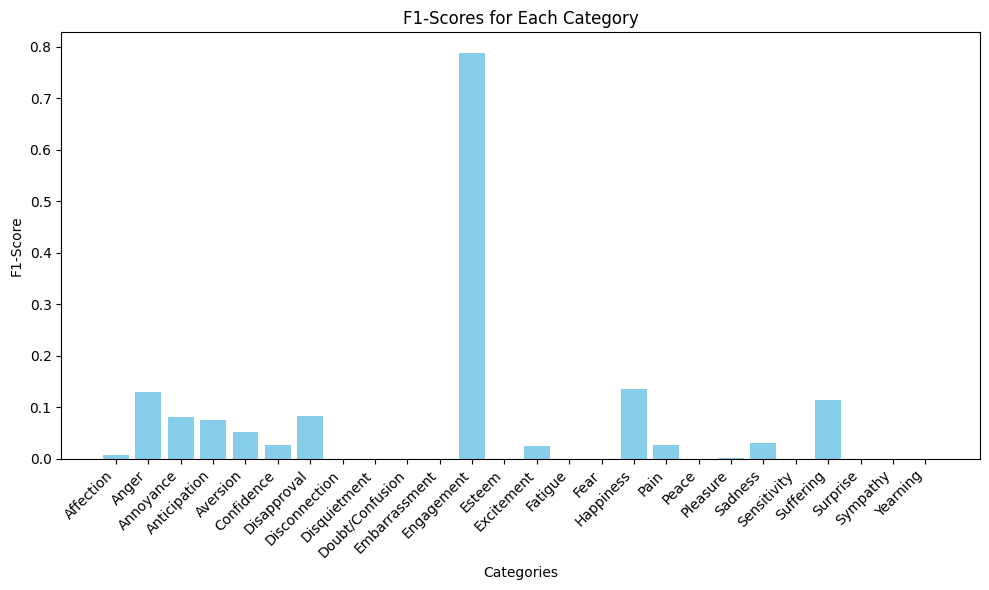

In [31]:

import matplotlib.pyplot as plt

# Assuming 'f1_scores' and 'categories' are already defined from the previous code
# Example data if not available (replace with actual data)
# f1_scores = [0.8, 0.7, 0.9, 0.6, 0.85]
# categories = ['A', 'B', 'C', 'D', 'E']


plt.figure(figsize=(10, 6))
plt.bar(categories, f1_scores, color='skyblue')
plt.xlabel("Categories")
plt.ylabel("F1-Score")
plt.title("F1-Scores for Each Category")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

Mean Accuracy: 0.8496246222193743
Affection: 0.8671386922115785
Anger: 0.9719561293905318
Annoyance: 0.9532139386366791
Anticipation: 0.5358878245175621
Aversion: 0.9695960016659725
Confidence: 0.5276967930029155
Disapproval: 0.9544634180202693
Disconnection: 0.8460363737331668
Disquietment: 0.8760238789393309
Doubt/Confusion: 0.8554768846314036
Embarrassment: 0.9815354713313897
Engagement: 0.6926280716368179
Esteem: 0.8628349298903235
Excitement: 0.5235318617242816
Fatigue: 0.9409968068860197
Fear: 0.9680688601971401
Happiness: 0.5449118422879355
Pain: 0.979730667777315
Peace: 0.8525614327363599
Pleasure: 0.7101207830070804
Sadness: 0.9477995279744551
Sensitivity: 0.9715396362626684
Suffering: 0.965847563515202
Surprise: 0.9394696654171872
Sympathy: 0.9160072192142164
Yearning: 0.9351659030959323


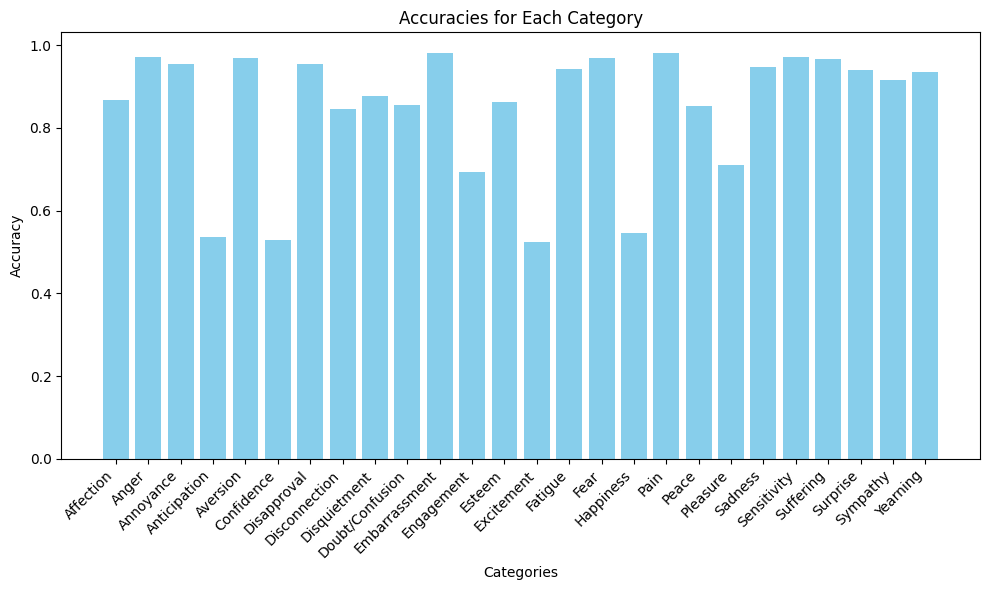

In [32]:

# Assuming 'cat_preds' and 'cat_labels' are already loaded from .mat files as in the provided code.
from sklearn.metrics import accuracy_score

# Calculate accuracy for each category
accuracies = []
for i in range(26):
    accuracy = accuracy_score(cat_labels[i, :], (cat_preds[i, :] > 0.5).astype(int))
    accuracies.append(accuracy)

# Calculate the mean accuracy
mean_accuracy = np.mean(accuracies)
print(f"Mean Accuracy: {mean_accuracy}")

# Print accuracy for each category
categories = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
              'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
              'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']
for i, accuracy in enumerate(accuracies):
    print(f"{categories[i]}: {accuracy}")

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.bar(categories, accuracies, color='skyblue')
plt.xlabel("Categories")
plt.ylabel("Accuracy")
plt.title("Accuracies for Each Category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Mean Precision: 0.3207480851641801
Affection: 1.0
Anger: 0.25
Annoyance: 0.5
Anticipation: 0.6585365853658537
Aversion: 0.2727272727272727
Confidence: 0.9230769230769231
Disapproval: 0.3
Disconnection: 0.0
Disquietment: 0.0
Doubt/Confusion: 0.0
Embarrassment: 0.0
Engagement: 0.845398773006135
Esteem: 0.0
Excitement: 0.8627450980392157
Fatigue: 0.0
Fear: 0.0
Happiness: 0.7901234567901234
Pain: 0.2
Peace: 0.0
Pleasure: 1.0
Sadness: 0.3157894736842105
Sensitivity: 0.0
Suffering: 0.42105263157894735
Surprise: 0.0
Sympathy: 0.0
Yearning: 0.0


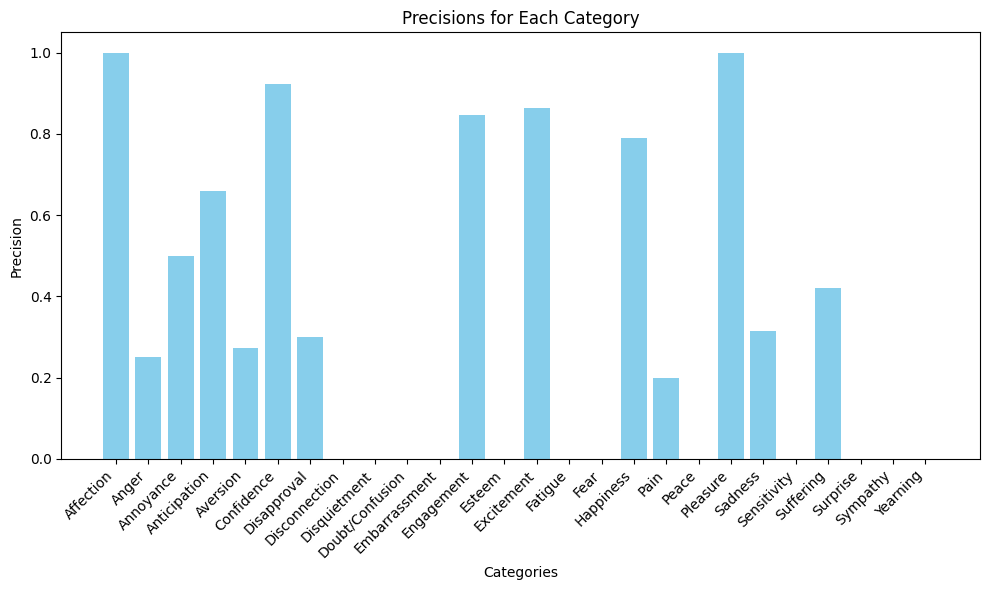

In [35]:

# Assuming 'cat_preds' and 'cat_labels' are already loaded from .mat files as in the provided code.
# Calculate precision for each category
precisions = []
for i in range(26):
    precision = precision_score(cat_labels[i, :], (cat_preds[i, :] > 0.5).astype(int), zero_division=0)
    precisions.append(precision)

# Calculate the mean precision
mean_precision = np.mean(precisions)
print(f"Mean Precision: {mean_precision}")

# Print precision for each category
categories = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence', 'Disapproval', 'Disconnection',
              'Disquietment', 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
              'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']
for i, precision in enumerate(precisions):
    print(f"{categories[i]}: {precision}")

# Plot precisions
plt.figure(figsize=(10, 6))
plt.bar(categories, precisions, color='skyblue')
plt.xlabel("Categories")
plt.ylabel("Precision")
plt.title("Precisions for Each Category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()